In [1]:
#library imports
import numpy as np #numpy is a math library 
import pandas as pd #pandas is a data library for manipulating information, my main library
import matplotlib as plt #equivalent to R for plotting
import seaborn as sns # a wrapper for matplot lib that makes automatically pretty graphs
from funcsLibPrep import * # this is a custom set of functions, primarily for dealing with applied biosystems data
from scipy import stats # for linear regression later
from scipy import optimize # for polynomials
## stats.gmean for exponential data!!

In [2]:
#display magic for seaborn and mpl
%matplotlib inline
sns.set(context="paper") #set seaborn graphs to be pretty

# nuclei counting match
We can approximate the # of nuclei in each by saying:
* x ng DNA * (1000 pg/1 ng) * (1 nuclei/6pg) = # nuclei relative to cq

In [3]:
# wrapper functions for nuclei <-> ng conversions
def ng_to_nuclei(ng):
    return ng * 1000 / 6
def nuclei_to_ng(nuclei):
    return  nuclei * 6 /1000

In [4]:
# additional wrapper functions for AB systems
def process(fn, data = None):
    sampleSetup = pd.read_excel(fn, 'Sample Setup', skiprows=7)
    df = importAmplification(fn).merge(sampleSetup)
    results = pd.read_excel(fn, skiprows=range(
        0, 7), sheet_name='Results').dropna(thresh=5).dropna(
            axis=1,
            thresh=5).drop(columns=['Task', 'Reporter',
                          'Quencher'])  #import results sheet, drop null rows, drop null columns, drop stupid columns
    results['Ct_clean'] = pd.to_numeric(results['Cт'], errors='coerce') #this is a cleaning line for later
    
    title = fn.rstrip('.xls')
    return df, results, title

# v1 for reference

In [5]:
df, results, title = process('200805_RachelBoyd_inSituPrimersv1.xls')
results.groupby(['Target Name', "Sample Name"]).agg({
    "Ct_clean": [stats.gmean, stats.gstd, 'mean', 'std']
}).round(
    2
)  #aggregate the data by the specified columns, and tell us the mean and std deviation of ct in each group. adding geometric mean and geometric standard deviation since these are differences on a log scale. Because n = 2, gmean and mean are the same, but gstd vs std is different. Rounding included for ease of interpretation.

Ct_clean                   
                           gmean  gstd   mean   std
Target Name Sample Name                            
18S         .5ng           18.57  1.03  18.58  0.47
            5ng            17.83  1.00  17.83  0.02
            NTC            33.03  1.06  33.05  1.86
Col1a       .5ng           21.65  1.01  21.65  0.24
            5ng            21.85  1.00  21.85  0.07
            NTC            35.21  1.08  35.26  2.61
Col1a(+)    .5ng           25.30  1.00  25.30  0.07
            5ng            34.65  1.06  34.68  2.08
            NTC              NaN   NaN    NaN   NaN
L1          .5ng           12.75  1.01  12.75  0.18
            5ng            15.09  1.00  15.09  0.05
            NTC              NaN   NaN    NaN   NaN
MTV         .5ng           22.48  1.01  22.48  0.13
            5ng            24.01  1.00  24.01  0.02
            NTC            34.99  1.00  34.99  0.13

This data set looks flipped -- 2 of 5 primer sets show a correct 3 cycle difference, but the opposite of what they are marked. An additional + control shows great amplification with .5 ng and no amplification with 5ng. The other 2 have erratic cq values. It's also possible that the Qubit value on the gDNA is inaccurate, and what we *think* is 5 ng is actually more like 20, and thus inhibitory. Still informative for practice!

# Nuclei approximations

In [6]:
#setting up approximate measurements
tipDict = {
    "P1000": 1.1,
    "P300": 1,
    "P20": .75,
    "P10": .6
}  

# fiji approximations
area_umSq = 10000 #measured with Fiji
nuclei = 25 #hand counted, not accounting for z stacking
density = nuclei / area_umSq #math

In [7]:
punch = pd.DataFrame.from_dict(tipDict, orient="index",
                               columns=['diam_mm']).reset_index().rename(
                                   {"index": "template"},
                                   axis=1)  #convert to dataframe + clean up
punch['area_mm_sq'] = punch['diam_mm'].apply(
    lambda diam: np.pi * np.square(diam / 2))
punch['area_uM_sq'] = punch['area_mm_sq'] * np.square(
    1000)  #important to do *squared* dimensional analysis
punch['total_nuclei'] = punch['area_uM_sq'] * density
punch['ng'] = punch.total_nuclei.apply(nuclei_to_ng)

In [8]:
templates = {'High(5ng)': 5, 'Low(0.5ng)': .5, 'NTC': 0}
temp = pd.DataFrame.from_dict(templates, orient="index",
                              columns=['ng']).reset_index().rename(
                                  {"index": "template"}, axis=1)
temp['total_nuclei'] = temp.ng.apply(ng_to_nuclei)

In [9]:
templates = punch.append(temp, sort = False)

In [10]:
templates.round(2) # ball park estimates for comparing to later data

,template,diam_mm,area_mm_sq,area_uM_sq,total_nuclei,ng
0,P1000,1.10,0.95,950331.78,2375.83,14.25
1,P300,1.00,0.79,785398.16,1963.50,11.78
2,P20,0.75,0.44,441786.47,1104.47,6.63
3,P10,0.60,0.28,282743.34,706.86,4.24
0,High(5ng),NaN,NaN,NaN,833.33,5.00
1,Low(0.5ng),NaN,NaN,NaN,83.33,0.50
2,NTC,NaN,NaN,NaN,0.00,0.00


# v3 standard curves of gel punches x primers for amplicons represented in the genome at ~standard curve amounts

In [11]:
fn = '200807_RBoyd_gel-ampliconStdcurve_v3.xls'
amp, results, title = process(fn)

## some visualization

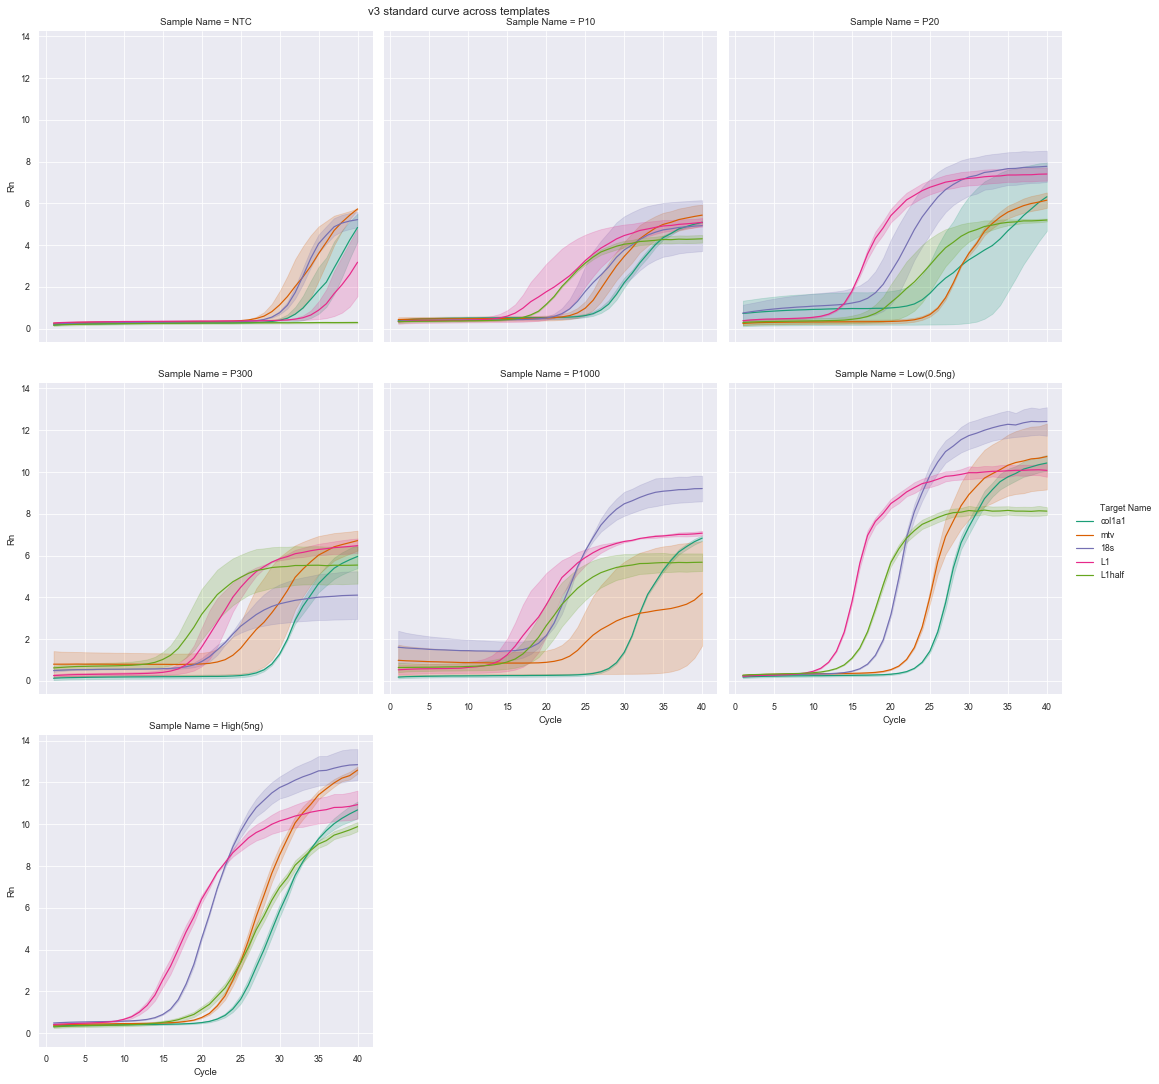

In [12]:
g = sns.relplot(x='Cycle',
            y='Rn',
            hue="Target Name",
            col="Sample Name",
            col_wrap = 3,
            data=amp,
            palette='Dark2', kind = "line")
g = g.fig.suptitle("v3 standard curve across templates",  x=0.4, y=1) # titling graphs is helpful

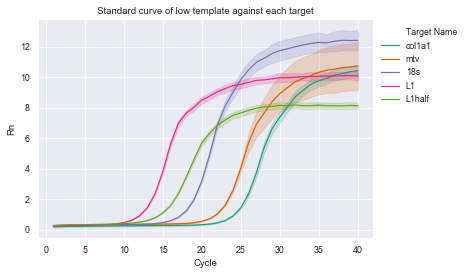

In [13]:
# the hopefully useful standard curve. some erratic stuff (the L1 half) -- next time I would halve the *template*, not the primers. otherwise a good start, I think.
ax = sns.lineplot(x='Cycle',
            y='Rn',
            hue="Target Name",
            data=amp.query('`Sample Name`.str.contains("Low")'),
            palette='Dark2')
sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)
ax.set_title("Standard curve of low template against each target")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

[Text(0.5, 1.0, 'Amplification plots of gDNA template')]

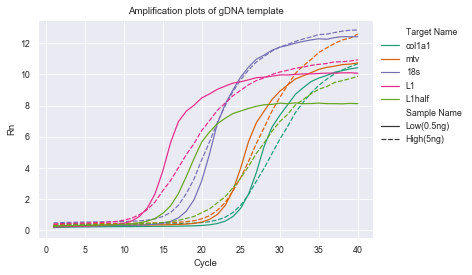

In [14]:
ax = sns.lineplot(x='Cycle',
            y='Rn',
            hue="Target Name",
                  style = "Sample Name",
            data=amp.query('`Sample Name`.str.contains("5")'),
            palette='Dark2', ci = None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title = "Amplification plots of gDNA template")
#plotting high vs low to investigate shapes

In [15]:
#Dropping the high because something is off with that -- this replicates the previous iteration, which implies something? odd with the template. Re-Qubit.
amp_noHigh = amp.query('`Sample Name` != "High(5ng)"')

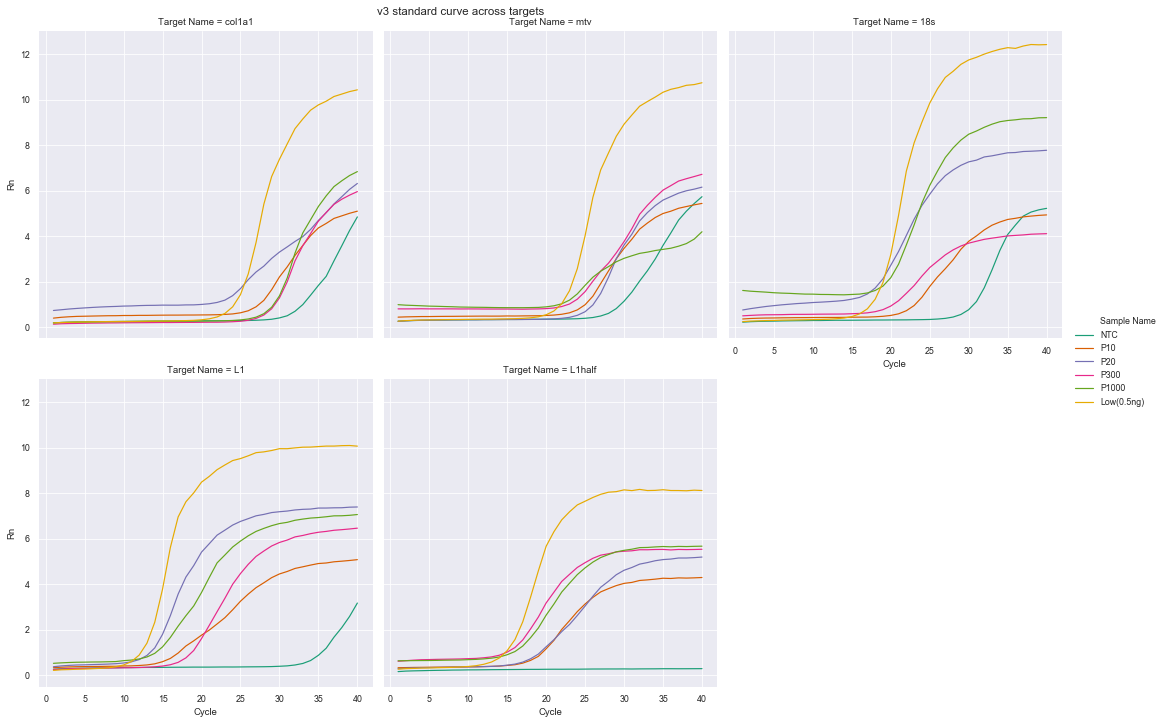

In [16]:
g = sns.relplot(
    x='Cycle',
    y='Rn',
    hue="Sample Name",
    col="Target Name",
    col_wrap=3,
    data=amp_noHigh,
    palette='Dark2',
    kind="line",
    ci=None
)  #dropping confidence intervals beacuse they make this more difficult to read
g = g.fig.suptitle("v3 standard curve across targets", x=0.4, y=1)

## diy standard curve

In [30]:
#dict for approximate values
genome_copies = {
    "col1a1": 2,
    "mtv": 10,
    "18s": 100,
    "L1": 3000,
    "L1half": 1500
}

In [31]:
calc = templates.add_suffix("_calc")
results['genomeCopies'] = results['Target Name'].map(genome_copies)
# d = results[['Well', 'Sample Name', 'Target Name', 'Cт', 'Ct_clean']].copy() #for my SANITY
d = results.merge(calc, left_on = ("Sample Name"), right_on ="template_calc", how = "outer").rename({"Sample Name": "SampleName"}, axis=1)

In [32]:
d['num_amplicons_calc'] = d['total_nuclei_calc']*d['genomeCopies']
d['log2_num_amplicons_calc'] = np.log2(d['num_amplicons_calc'].replace(0, np.nan)).fillna(0)

In [33]:
stds = d.query('SampleName.str.contains("Low")')

x = stds['log2_num_amplicons_calc']
y = stds['Ct_clean']
y_range = [y.min().round(2), y.max().round()]

m, b, r_value, p_value, std_err = stats.linregress(x, y)
ct_line = m*x + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)

# considering range, not really interested in working  too far outside our range
is_ranged = d['Ct_clean'].between(y.min(), y.max())
ranged = d[is_ranged].copy()
ranged['log2_num_amplicons_curveExp'] = (ranged['Ct_clean'] - b) / m
ranged['num_amplicons_curveExp'] = np.exp2(ranged['log2_num_amplicons_curveExp'])

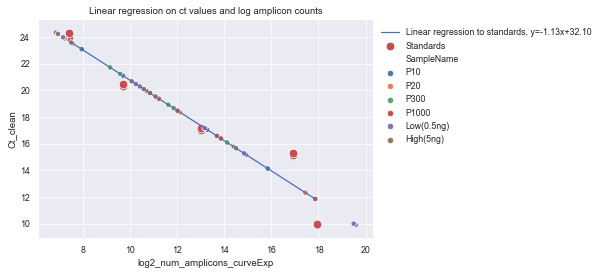

In [44]:
ax = sns.scatterplot(x, y, marker='o', label='Standards', color= "r", s= 75, alpha = 1)
ax = sns.lineplot(x,
                  ct_line,
                  label='Linear regression to standards, {}'.format(line_eq),
                  ax=ax)
ax = sns.scatterplot('log2_num_amplicons_curveExp',
                     'Ct_clean',
                     data=ranged,
                     hue="SampleName", s= 30)
# ax = sns.pointplot('log2_num_amplicons_curvecalc',
#                    'Ct_clean',
#                    data=ranged,
#                    join=False,
#                    hue='SampleName', dodge = .5, markers = "x", ax= ax)
sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title="Linear regression on ct values and log amplicon counts")

fig = ax.get_figure()

In [45]:
x= 'log2_num_amplicons_calc'
y= 'log2_num_amplicons_curveExp'
m, b, r_value, p_value, std_err = stats.linregress(ranged[x], ranged[y])
ct_line = m*ranged[x] + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)

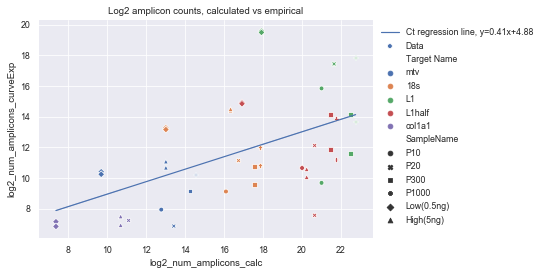

In [46]:
ax = sns.lineplot(x,
                  ct_line,
                  label='Ct regression line, {}'.format(line_eq),
                  data=ranged)
ax = sns.scatterplot(x, y, label="Data", data=ranged, hue="Target Name", style = "SampleName", ax=ax)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title="Log2 amplicon counts, calculated vs empirical")

sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)

fig = ax.get_figure()
# ax

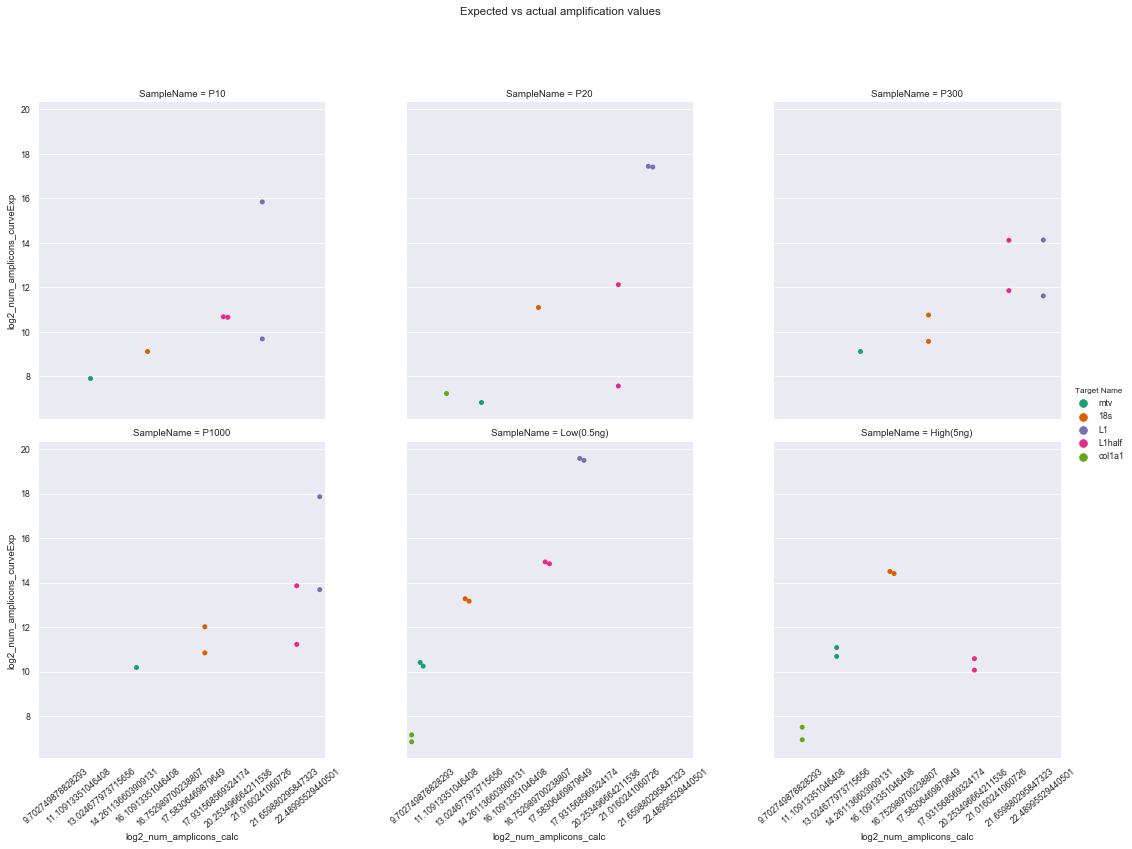

In [47]:
# not happy with these figure ticks but ok for now
g = sns.catplot(x,
                y,
                hue="Target Name",
                col="SampleName",
                col_wrap=3,
                data=ranged,
                palette='Dark2',
                kind="swarm",
                sharex=True,
                sharey=True)

g.fig.suptitle("Expected vs actual amplification values",  x=0.5, y=1.1)

# fmt = lambda x: "{:.2f}%".format(x)


for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=40)
#     ax.set_xticklabels(xlabels)